#### Copyright 2019 The TensorFlow Authors.

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')

In [3]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 불균형 데이터 분류

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 </a>   </td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이 튜토리얼에서는 한 클래스의 예시의 수가 다른 클래스보다 훨씬 많은 매우 불균형적인 데이터세트를 분류하는 방법을 소개합니다. Kaggle에서 호스팅되는 [신용 카드 부정 행위 탐지](https://www.kaggle.com/mlg-ulb/creditcardfraud) 데이터세트를 사용하여 작업해 보겠습니다. 총 284,807건의 거래에서 492건의 부정 거래를 탐지하는 것을 목표로 합니다. [Keras](../../guide/keras/overview.ipynb)를 사용하여 모델 및 [클래스 가중치](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model)를 정의하여 불균형 데이터에서 모델을 학습시켜 보겠습니다.

이 튜토리얼에는 다음을 수행하기 위한 완전한 코드가 포함되어 있습니다.

- Pandas를 사용하여 CSV 파일 로드.
- 학습, 검증 및 테스트세트 작성.
- Keras를 사용하여 모델을 정의하고 학습(클래스 가중치 설정 포함)
- 다양한 측정 기준(정밀도 및 재현율 포함)을 사용하여 모델 평가
- 다음과 같은 불균형 데이터를 처리하기 위한 일반적인 기술 사용
    - 클래스 가중치
    - 오버샘플링


## 설정

In [4]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [62]:
mpl.rcParams['figure.figsize'] = (12, 3)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## 데이터 처리 및 탐색

### Kaggle 신용 카드 부정 행위 데이터 세트

Pandas는 구조적 데이터를 로드하고 처리하는 데 유용한 여러 유틸리티가 포함된 Python 라이브러리입니다. CSV를 Pandas [데이터 프레임](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame)으로 다운로드하는 데 사용할 수 있습니다.

참고: 이 데이터세트는 빅데이터 마이닝 및 부정 행위 감지에 대한 Worldline과 ULB(Université Libre de Bruxelles) [Machine Learning Group](http://mlg.ulb.ac.be)의 연구 협업을 통해 수집 및 분석되었습니다. 관련 주제에 관한 현재 및 과거 프로젝트에 대한 자세한 내용은 [여기](https://www.researchgate.net/project/Fraud-detection-5)를 참조하거나 [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) 프로젝트 페이지에서 확인할 수 있습니다.

In [26]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [27]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### 클래스 레이블 불균형 검사

데이터세트 불균형을 살펴보겠습니다.:

In [28]:
np.bincount([0,2,2,1,9,1,1,1]) # '0' 1개, '1' 4개, '2' 2개, '9' 1개

array([1, 4, 2, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [29]:
neg, pos = np.bincount(raw_df['Class'])
neg
pos
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

284315

492

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



이를 통해 양성 샘플 일부를 확인할 수 있습니다.

### 데이터 정리, 분할 및 정규화

원시 데이터에는 몇 가지 문제가 있습니다. 먼저 `Time` 및 `Amount` 열이 매우 가변적이므로 직접 사용할 수 없습니다. (의미가 명확하지 않으므로) `Time` 열을 삭제하고 `Amount` 열의 로그를 가져와 범위를 줄입니다.

In [63]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

In [64]:
cleaned_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<AxesSubplot:>

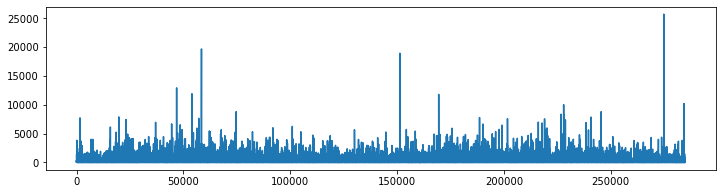

In [65]:
cleaned_df['Amount'].plot()

<AxesSubplot:>

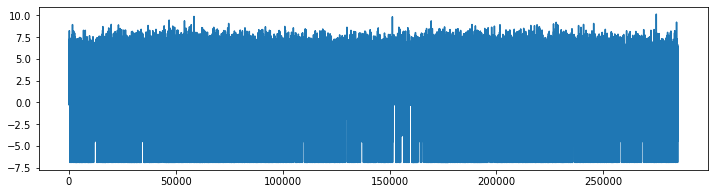

In [66]:
# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)
cleaned_df['Log Ammount'].plot()

데이터세트를 학습, 검증 및 테스트 세트로 분할합니다. 검증 세트는 모델 피팅 중에 사용되어 손실 및 메트릭을 평가하지만 해당 모델은 이 데이터에 적합하지 않습니다. 테스트 세트는 훈련 단계에서는 전혀 사용되지 않으며 마지막에만 사용되어 모델이 새 데이터로 일반화되는 정도를 평가합니다. 이는 훈련 데이터가 부족하여 [과대적합](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting)이 크게 문제가 되는 불균형 데이터세트에서 특히 중요합니다.

In [67]:
# Use a utility from sklearn to split and shuffle your dataset.
cleaned_df.shape
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

len(test_df)/len(cleaned_df)
len(train_df)/len(cleaned_df)
len(val_df)/len(cleaned_df)

(284807, 30)

0.20000210668979343

0.6399983146481653

0.15999957866204131

In [69]:
train_df.columns
train_labels

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class',
       'Log Ammount'],
      dtype='object')

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [70]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

sklearn StandardScaler를 사용하여 입력 특성을 정규화하면 평균은 0으로, 표준 편차는 1로 설정됩니다.

참고: `StandardScaler`는 모델이 유효성 검사 또는 테스트 세트를 참고하는지 여부를 확인하기 위해 `train_features`를 사용하는 경우에만 적합합니다. 

In [9]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


주의: 모델을 배포하려면 전처리 계산을 유지하는 것이 중요합니다. 따라서 레이어로 구현하고 내보내기 전에 모델에 연결하는 것이 가장 쉬운 방법입니다.


### 데이터 분포 살펴보기

다음으로 몇 가지 특성에 대한 양 및 음의 예시 분포를 비교해 보겠습니다. 이 때 스스로 검토할 사항은 다음과 같습니다.

- 이와 같은 분포가 합리적인가?
    - 예, 이미 입력을 정규화했으며 대부분 `+/- 2` 범위에 집중되어 있습니다.
- 분포 간 차이를 알 수 있습니까?
    - 예, 양의 예에는 극단적 값의 비율이 훨씬 높습니다.

/home/kbuilder/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/kbuilder/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


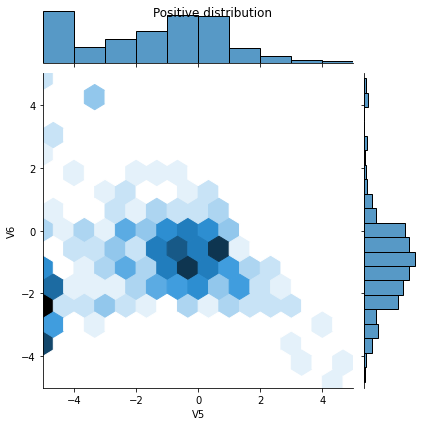

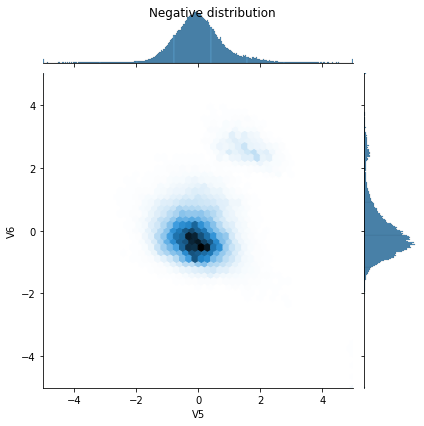

In [10]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

## 모델 및 메트릭 정의

조밀하게 연결된 숨겨진 레이어, 과대적합을 줄이기 위한 [드롭아웃](https://developers.google.com/machine-learning/glossary/#dropout_regularization) 레이어, 거래 사기 가능성을 반환하는 시그모이드 출력 레이어로 간단한 신경망을 생성하는 함수를 정의합니다. 

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### 유용한 메트릭 이해하기

위에서 정의한 몇 가지 메트릭은 모델을 통해 계산할 수 있으며 성능을 평가할 때 유용합니다.

- **허위** 음성과 **허위** 양성은 **잘못** 분류된 샘플입니다.
- **실제** 음성과 **실제** 양성은 **올바로** 분류된 샘플입니다.
- **정확도**는 올바로 분류된 예의 비율입니다.

> $\frac{\text{true samples}}{\text{total samples}}$

- **정밀도**는 올바르게 분류된 **예측** 양성의 비율입니다.

> $\frac{\text{true positives}}{\text{true positives + false positives}}$

- **재현율**은 올바르게 분류된 **실제** 양성의 비율입니다.

> $\frac{\text{true positives}}{\text{true positives + false negatives}}$

- **AUC**는 ROC-AUC(Area Under the Curve of a Receiver Operating Characteristic) 곡선을 의미합니다. 이 메트릭은 분류자가 임의의 양성 샘플 순위를 임의의 음성 샘플 순위보다 높게 지정할 확률과 같습니다.
- **AUPRC**는 PR curve AUC를 의미합니다. 이 메트릭은 다양한 확률 임계값에 대한 정밀도-재현율 쌍을 계산합니다.

참고: 정확도는 이 작업에 유용한 측정 항목이 아닙니다. 항상 False를 예측해야 이 작업에서 99.8% 이상의 정확도를 얻을 수 있습니다.

더 읽어보기:

- [참 vs. 거짓, 양성 vs. 음성](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
- [정확성](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
- [정밀도와 재현율](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
- [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
- [Precision-Recall과 ROC 곡선의 관계](https://www.biostat.wisc.edu/~page/rocpr.pdf)

## 기준 모델

### 모델 구축

이제 앞서 정의한 함수를 사용하여 모델을 만들고 학습해 보겠습니다. 모델은 기본 배치 크기인 2048보다 큰 배치 크기를 사용하는 것이 좋습니다. 각 배치에서 양성 샘플을 일부 포함시켜 적절한 기회를 얻는 것이 중요합니다. 배치 크기가 너무 작으면 부정 거래 예시를 제대로 학습할 수 없습니다.

참고: 이 모델은 클래스의 불균형을 잘 다루지 못합니다. 이를 이 튜토리얼의 뒷부분에서 개선하게 될 겁니다.

In [12]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


모델을 실행하여 테스트해보겠습니다.

In [14]:
model.predict(train_features[:10])

array([[0.24614692],
       [0.54844296],
       [0.2355674 ],
       [0.5151356 ],
       [0.39113   ],
       [0.386738  ],
       [0.32651168],
       [0.41346052],
       [0.11890455],
       [0.34378132]], dtype=float32)

### 선택사항: 초기 바이어스를 올바로 설정합니다.

이와 같은 초기 추측은 적절하지 않습니다. 데이터세트가 불균형하다는 것을 알고 있으니까요. 출력 레이어의 바이어스를 설정하여 해당 데이터세트를 반영하면(참조: [신경망 훈련 방법: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)) 초기 수렴에 유용할 수 있습니다.

기본 바이어스 초기화를 사용하면 손실은 약 `math.log(2) = 0.69314` 

In [15]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4902


올바른 바이어스 설정은 다음에서 가능합니다.

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$ $$ b_0 = -log_e(1/p_0 - 1) $$ $$ b_0 = log_e(pos/neg)$$

In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

이를 초기 바이어스로 설정하면 모델은 훨씬 더 합리적으로 초기 추측을 할 수 있습니다.

`pos/total = 0.0018`에 가까울 것입니다.

In [17]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.0108717 ],
       [0.00171685],
       [0.0009581 ],
       [0.00057781],
       [0.00524487],
       [0.00081512],
       [0.00155083],
       [0.0006627 ],
       [0.00218084],
       [0.00183015]], dtype=float32)

이 초기화를 통해서 초기 손실은 대략 다음과 같아야합니다.:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0145


이 초기 손실은 단순한 상태의 초기화에서 발생했을 때 보다 약 50배 적습니다.

이런 식으로 모델은 처음 몇 epoch를 쓰며 양성 예시가 거의 없다는 것을 학습할 필요는 없습니다. 이렇게 하면 학습을 하면서 손실된 플롯을 더 쉽게 파악할 수 있습니다.

### 초기 가중치 체크 포인트

다양한 학습 과정을 비교하려면 이 초기 모델의 가중치를 체크포인트 파일에 보관하고 학습 전에 각 모델에 로드합니다.

In [19]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### 바이어스 수정이 도움이 되는지 확인하기

계속 진행하기 전에 조심스러운 바이어스 초기화가 실제로 도움이 되었는지 빠르게 확인하십시오

정교한 초기화를 한 모델과 하지 않은 모델을 20 epoch 학습시키고 손실을 비교합니다. 

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [21]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [22]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch, history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

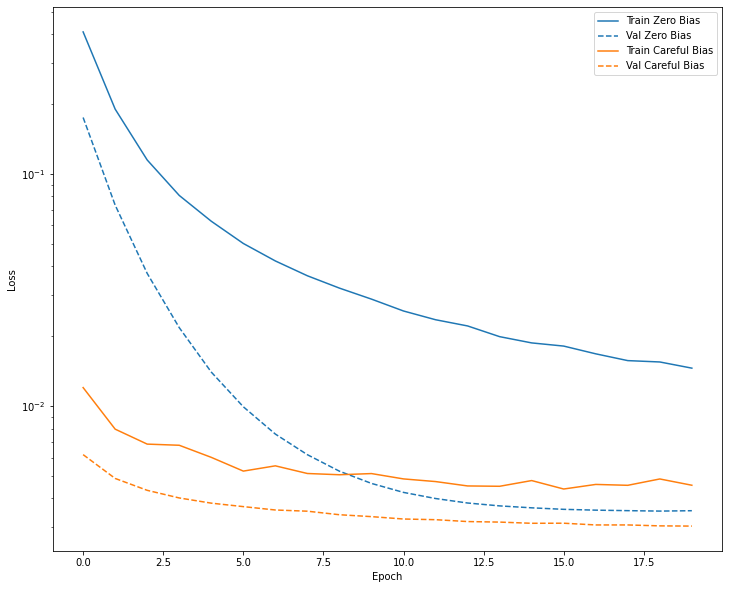

In [23]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

위의 그림에서 명확히 알 수 있듯이, 검증 손실 측면에서 이와 같은 정교한 초기화에는 분명한 이점이 있습니다. 

### 모델 학습

In [24]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 3s 14ms/step - loss: 0.0119 - tp: 144.0000 - fp: 49.0000 - tn: 227398.0000 - fn: 254.0000 - accuracy: 0.9987 - precision: 0.7461 - recall: 0.3618 - auc: 0.7577 - prc: 0.3668 - val_loss: 0.0063 - val_tp: 27.0000 - val_fp: 7.0000 - val_tn: 45477.0000 - val_fn: 58.0000 - val_accuracy: 0.9986 - val_precision: 0.7941 - val_recall: 0.3176 - val_auc: 0.8993 - val_prc: 0.6408
Epoch 2/100
90/90 [==============================] - 1s 6ms/step - loss: 0.0080 - tp: 122.0000 - fp: 31.0000 - tn: 181932.0000 - fn: 191.0000 - accuracy: 0.9988 - precision: 0.7974 - recall: 0.3898 - auc: 0.8251 - prc: 0.4363 - val_loss: 0.0049 - val_tp: 40.0000 - val_fp: 8.0000 - val_tn: 45476.0000 - val_fn: 45.0000 - val_accuracy: 0.9988 - val_precision: 0.8333 - val_recall: 0.4706 - val_auc: 0.9233 - val_prc: 0.7260
Epoch 3/100
90/90 [==============================] - 1s 6ms/step - loss: 0.0072 - tp: 141.0000 - fp: 26.0000 - tn: 181937.0000 - fn: 172.0000 - accuracy:

### 학습 이력 확인

이 섹션에서는 훈련 및 검증 세트에서 모델의 정확도 및 손실에 대한 플롯을 생성합니다. 이는 과대적합 확인에 유용하며 [과대적합 및 과소적합](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) 튜토리얼에서 자세히 알아볼 수 있습니다.

또한, 위에서 만든 모든 메트릭에 대해 다음과 같은 플롯을 생성할 수 있습니다. 거짓 음성이 예시에 포함되어 있습니다.

In [25]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


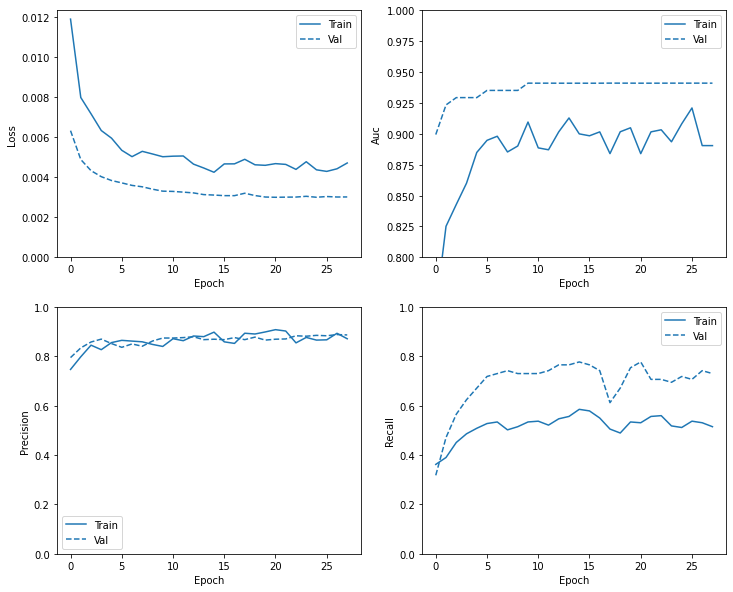

In [26]:
plot_metrics(baseline_history)

참고: 검증 곡선은 일반적으로 훈련 곡선보다 성능이 좋습니다. 이는 주로 모델을 평가할 때 drop out 레이어가 활성화 되지 않았기 때문에 발생합니다.

### 메트릭 평가

[혼동 행렬](https://developers.google.com/machine-learning/glossary/#confusion_matrix)을 사용하여 실제 레이블과 예측 레이블을 요약할 수 있습니다. 여기서 X축은 예측 레이블이고 Y축은 실제 레이블입니다.

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [28]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

테스트 데이터세트에서 모델을 평가하고 위에서 생성한 메트릭 결과를 표시합니다.

loss :  0.003450451185926795
tp :  60.0
fp :  9.0
tn :  56859.0
fn :  34.0
accuracy :  0.9992451071739197
precision :  0.8695651888847351
recall :  0.6382978558540344
auc :  0.9199696779251099
prc :  0.77667635679245

Legitimate Transactions Detected (True Negatives):  56859
Legitimate Transactions Incorrectly Detected (False Positives):  9
Fraudulent Transactions Missed (False Negatives):  34
Fraudulent Transactions Detected (True Positives):  60
Total Fraudulent Transactions:  94


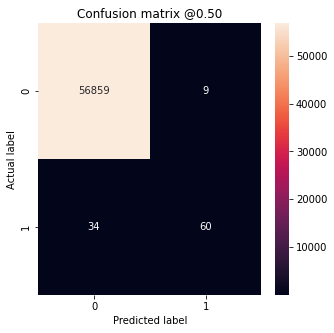

In [29]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

만약 모델이 모두 완벽하게 예측했다면 [대각행렬](https://en.wikipedia.org/wiki/Diagonal_matrix)이 되어 예측 오류를 보여주며 대각선 값은 0이 됩니다. 이와 같은 경우, 매트릭에 거짓 양성이 상대적으로 낮음을 확인할 수 있으며 이를 통해 플래그가 잘못 지정된 합법적인 거래가 상대적으로 적다는 것을 알 수 있습니다. 그러나 거짓 양성 수를 늘리더라도 거짓 음성을 더 낮추고 싶을 수 있습니다. 거짓 음성은 부정 거래가 발생할 수 있지만, 거짓 양성은 고객에게 이메일을 보내 카드 활동 확인을 요청할 수 있기 때문에 거짓 음성을 낮추는 것이 더 바람직할 수 있기 때문입니다.

### ROC 플로팅

이제 [ROC](https://developers.google.com/machine-learning/glossary#ROC)을 플로팅 하십시오. 이 그래프는 출력 임계값을 조정하기만 해도 모델이 도달할 수 있는 성능 범위를 한눈에 보여주기 때문에 유용합니다.

In [30]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

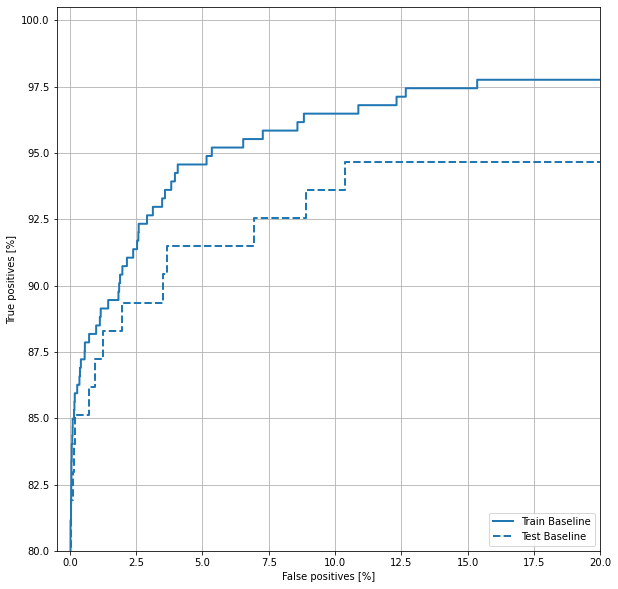

In [31]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

### AUPRC 플로팅

Now plot the [AUPRC](https://developers.google.com/machine-learning/glossary?hl=en#PR_AUC). Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.


In [32]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

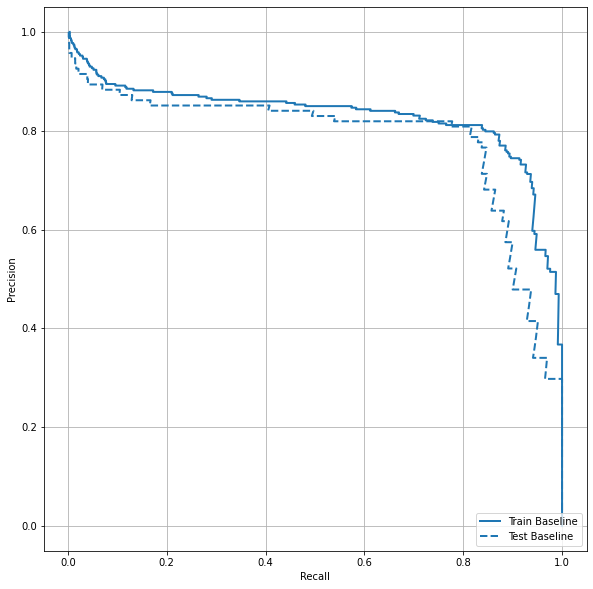

In [33]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

정밀도가 비교적 높은 것 같지만 재현율과 ROC 곡선(AUC) 아래 면적이 높지 않습니다. 분류자가 정밀도와 재현율 모두를 최대화하려고 하면 종종 어려움에 직면하는데, 불균형 데이터세트로 작업할 때 특히 그렇습니다. 관심있는 문제의 맥락에서 다른 유형의 오류 비용을 고려하는 것이 중요합니다. 이 예시에서 거짓 음성(부정 거래를 놓친 경우)은 금전적 비용이 들 수 있지만 , 거짓 양성(거래가 사기 행위로 잘못 표시됨)은 사용자 만족도를 감소시킬 수 있습니다.

## 클래스 가중치

### 클래스 가중치 계산

목표는 부정 거래를 식별하는 것이지만, 작업할 수 있는 양성 샘플이 많지 않지 않기 때문에 분류자는 이용 가능한 몇 가지 예에 가중치를 두고자 할 것입니다. 매개 변수를 통해 각 클래스에 대한 Keras 가중치를 전달한다면 이 작업을 수행할 수 있습니다. 이로 인해 모델은 더 적은 클래스 예시에 "더 많은 관심을 기울일" 수 있습니다.

In [34]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### 클래스 가중치로 모델 교육

이제 해당 모델이 예측에 어떤 영향을 미치는지 확인하기 위하여 클래스 가중치로 모델을 재 교육하고 평가해 보십시오.

참고: `class_weights`를 사용하면 손실 범위가 변경됩니다. 이는 옵티마이저에 따라 훈련의 안정성에 영향을 미칠 수 있습니다. `tf.keras.optimizers.SGD`와 같이 단계 크기가 그래디언트의 크기에 따라 달라지는 옵티마이저는 실패할 수 있습니다. 여기서 사용된 옵티마이저인 `tf.keras.optimizers.Adam`은 스케일링 변경의 영향을 받지 않습니다. 또한, 가중치로 인해 총 손실은 두 모델 간에 비교할 수 없습니다.

In [35]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
90/90 [==============================] - 3s 14ms/step - loss: 2.4293 - tp: 140.0000 - fp: 175.0000 - tn: 238656.0000 - fn: 267.0000 - accuracy: 0.9982 - precision: 0.4444 - recall: 0.3440 - auc: 0.7575 - prc: 0.2604 - val_loss: 0.0065 - val_tp: 48.0000 - val_fp: 10.0000 - val_tn: 45474.0000 - val_fn: 37.0000 - val_accuracy: 0.9990 - val_precision: 0.8276 - val_recall: 0.5647 - val_auc: 0.9214 - val_prc: 0.6476
Epoch 2/100
90/90 [==============================] - 1s 6ms/step - loss: 1.2689 - tp: 165.0000 - fp: 337.0000 - tn: 181626.0000 - fn: 148.0000 - accuracy: 0.9973 - precision: 0.3287 - recall: 0.5272 - auc: 0.8348 - prc: 0.4089 - val_loss: 0.0073 - val_tp: 67.0000 - val_fp: 13.0000 - val_tn: 45471.0000 - val_fn: 18.0000 - val_accuracy: 0.9993 - val_precision: 0.8375 - val_recall: 0.7882 - val_auc: 0.9319 - val_prc: 0.6983
Epoch 3/100
90/90 [==============================] - 1s 6ms/step - loss: 1.0040 - tp: 186.0000 - fp: 588.0000 - tn: 181375.0000 - fn: 127.0000 - accu

### 학습 이력 조회

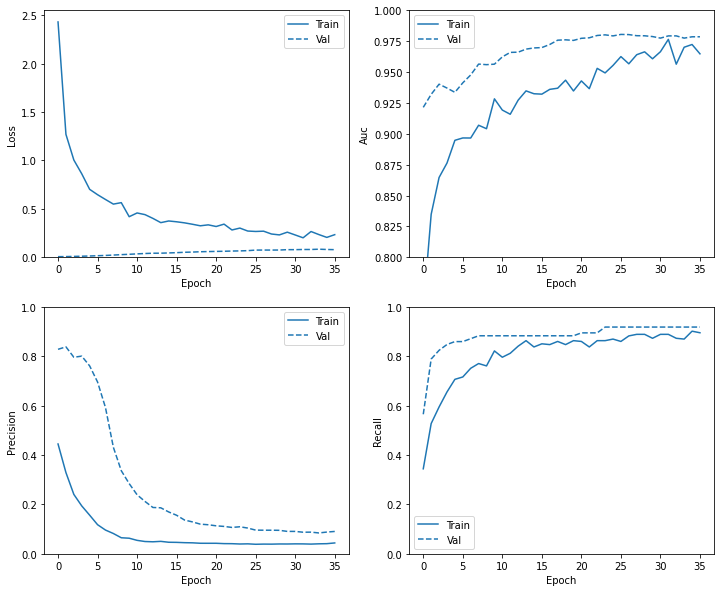

In [36]:
plot_metrics(weighted_history)

### 매트릭 평가

In [37]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.07310998439788818
tp :  82.0
fp :  970.0
tn :  55898.0
fn :  12.0
accuracy :  0.9827604293823242
precision :  0.07794676721096039
recall :  0.8723404407501221
auc :  0.9701933264732361
prc :  0.5456250905990601

Legitimate Transactions Detected (True Negatives):  55898
Legitimate Transactions Incorrectly Detected (False Positives):  970
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  82
Total Fraudulent Transactions:  94


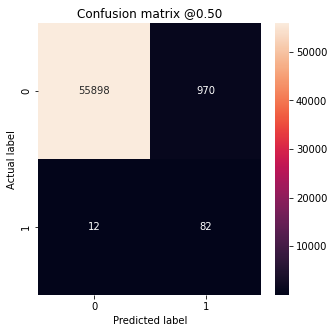

In [38]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

여기서 클래스 가중치를 사용하면 거짓 양성이 더 많기 때문에 정확도와 정밀도는 더 낮지만, 반대로 참 양성이 많으므로 재현율과 AUC는 더 높다는 것을 알 수 있습니다. 정확도가 낮음에도 불구하고 이 모델은 재현율이 더 높습니다(더 많은 부정 거래 식별). 물론 두 가지 유형의 오류 모두 비용이 발생합니다(많은 합법 거래를 사기로 표시하여 사용자를 번거롭게 하는 것은 바람직하지 않으므로). 따라서, 여러 유형 오류 간 절충 사항을 신중하게 고려해야 합니다.

### ROC 플로팅

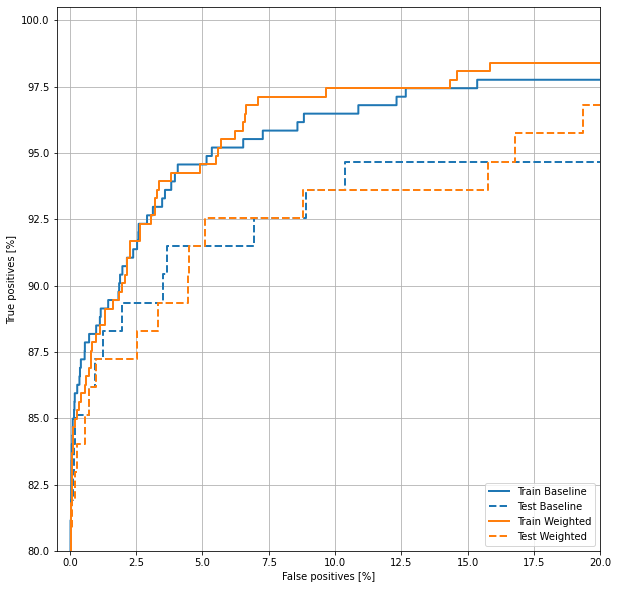

In [39]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

### AUPRC 플로팅

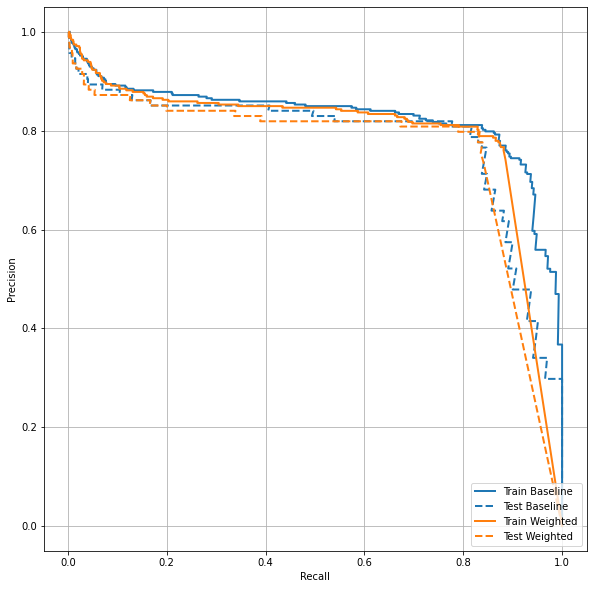

In [40]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

## 오버샘플링

### 소수 계급 과대 표본

관련된 접근 방식은 소수 클래스를 오버 샘플링 하여 데이터 세트를 리 샘플링 하는 것입니다.

In [41]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### NumPy 사용

긍정적인 예에서 적절한 수의 임의 인덱스를 선택하여 데이터 세트의 균형을 수동으로 조정할 수 있습니다.:

In [42]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181963, 29)

In [43]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363926, 29)

#### `tf.data` 사용

`tf.data`를 사용하는 경우 균형있는 예를 생성하는 가장 쉬운 방법은 `positive`와 `negative` 데이터세트로 시작하여 이들을 병합하는 것입니다. [tf.data guide](../../guide/data.ipynb)에서 더 많은 예를 참조하시기 바랍니다.

In [44]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

각 데이터 세트는 `(feature, label)` 쌍으로 되어 있습니다.

In [45]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-3.74818081  3.00481166 -5.          5.         -5.         -1.78734344
 -5.          3.88414884 -5.         -5.          5.         -5.
  0.55035681 -5.         -0.49442542 -5.         -5.         -5.
  4.95463284  0.93387724  2.95291341  0.04553031 -0.02054476  1.03199931
 -0.10099318  0.34178886  3.51642319  0.9441714  -0.25312576]

Label:  1


`experimental.sample_from_datasets` 를 사용하여 두 가지를 병합합니다.:

In [46]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

Instructions for updating:
Use `tf.data.Dataset.random(...)`.


In [47]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.50244140625


이 데이터 세트를 사용하려면 epoch당 스텝 수가 필요합니다.

이 경우 "epoch"의 정의는 명확하지 않습니다. 각 음성 예시를 한 번 볼 때 필요한 배치 수라고 해봅시다.

In [48]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### 오버 샘플링 된 데이터에 대한 학습

이제 클래스 가중치를 사용하는 대신 리 샘플링 된 데이터 세트로 모델을 학습하여 이러한 방법이 어떻게 비교되는지 확인하십시오.

참고: 긍정적인 예를 복제하여 데이터가 균형을 이루었기 때문에 총 데이터 세트 크기가 더 크고 각 세대가 더 많은 학습 단계를 위해 실행됩니다. 

In [49]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 9s 28ms/step - loss: 0.5130 - tp: 215130.0000 - fp: 50880.0000 - tn: 290410.0000 - fn: 69886.0000 - accuracy: 0.8072 - precision: 0.8087 - recall: 0.7548 - auc: 0.8612 - prc: 0.8897 - val_loss: 0.2428 - val_tp: 75.0000 - val_fp: 683.0000 - val_tn: 44801.0000 - val_fn: 10.0000 - val_accuracy: 0.9848 - val_precision: 0.0989 - val_recall: 0.8824 - val_auc: 0.9576 - val_prc: 0.7392
Epoch 2/100
278/278 [==============================] - 7s 26ms/step - loss: 0.2451 - tp: 237128.0000 - fp: 13237.0000 - tn: 271244.0000 - fn: 47735.0000 - accuracy: 0.8929 - precision: 0.9471 - recall: 0.8324 - auc: 0.9581 - prc: 0.9672 - val_loss: 0.1324 - val_tp: 76.0000 - val_fp: 618.0000 - val_tn: 44866.0000 - val_fn: 9.0000 - val_accuracy: 0.9862 - val_precision: 0.1095 - val_recall: 0.8941 - val_auc: 0.9689 - val_prc: 0.7532
Epoch 3/100
278/278 [==============================] - 7s 26ms/step - loss: 0.1919 - tp: 240924.0000 - fp: 8887.0000 - tn: 275710

Epoch 20/100
278/278 [==============================] - 7s 25ms/step - loss: 0.0576 - tp: 284070.0000 - fp: 10193.0000 - tn: 274197.0000 - fn: 884.0000 - accuracy: 0.9805 - precision: 0.9654 - recall: 0.9969 - auc: 0.9976 - prc: 0.9973 - val_loss: 0.0242 - val_tp: 78.0000 - val_fp: 455.0000 - val_tn: 45029.0000 - val_fn: 7.0000 - val_accuracy: 0.9899 - val_precision: 0.1463 - val_recall: 0.9176 - val_auc: 0.9680 - val_prc: 0.7817
Epoch 21/100
278/278 [==============================] - 7s 25ms/step - loss: 0.0553 - tp: 283954.0000 - fp: 9994.0000 - tn: 274718.0000 - fn: 678.0000 - accuracy: 0.9813 - precision: 0.9660 - recall: 0.9976 - auc: 0.9977 - prc: 0.9974 - val_loss: 0.0229 - val_tp: 78.0000 - val_fp: 425.0000 - val_tn: 45059.0000 - val_fn: 7.0000 - val_accuracy: 0.9905 - val_precision: 0.1551 - val_recall: 0.9176 - val_auc: 0.9682 - val_prc: 0.7815
Epoch 22/100
278/278 [==============================] - 7s 25ms/step - loss: 0.0537 - tp: 284026.0000 - fp: 9815.0000 - tn: 274976.00

만약 훈련 프로세스가 각 기울기 업데이트에서 전체 데이터 세트를 고려하는 경우, 이 오버 샘플링은 기본적으로 클래스 가중치와 동일합니다.

그러나 여기에서와 같이, 모델을 배치별로 훈련할 때 오버샘플링된 데이터는 더 부드러운 그래디언트 신호를 제공합니다. 각 양성 예시가 하나의 배치에서 큰 가중치를 가지기보다, 매번 여러 배치에서 작은 가중치를 갖기 때문입니다.

이 부드러운 기울기 신호는 모델을 더 쉽게 훈련 할 수 있습니다.

### 교육 이력 확인

학습 데이터의 분포가 검증 및 테스트 데이터와 완전히 다르기 때문에 여기서 측정 항목의 분포가 다를 수 있습니다. 

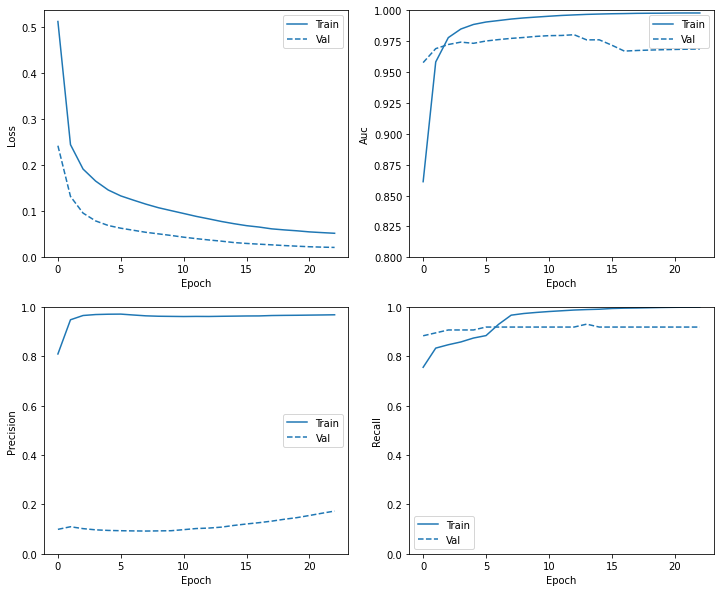

In [50]:
plot_metrics(resampled_history)

### 재교육


균형 잡힌 데이터에 대한 훈련이 더 쉽기 때문에 위의 훈련 절차가 빠르게 과적합 될 수 있습니다.

epoch를 나누어 `tf.keras.callbacks.EarlyStopping`를 보다 세밀하게 제어하여 훈련 중단 시점을 정합니다.

In [51]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 3s 65ms/step - loss: 1.3354 - tp: 9534.0000 - fp: 6307.0000 - tn: 59758.0000 - fn: 10930.0000 - accuracy: 0.8008 - precision: 0.6019 - recall: 0.4659 - auc: 0.8067 - prc: 0.6533 - val_loss: 0.5710 - val_tp: 67.0000 - val_fp: 11408.0000 - val_tn: 34076.0000 - val_fn: 18.0000 - val_accuracy: 0.7493 - val_precision: 0.0058 - val_recall: 0.7882 - val_auc: 0.8237 - val_prc: 0.4174
Epoch 2/1000
20/20 [==============================] - 1s 28ms/step - loss: 0.8414 - tp: 12394.0000 - fp: 6307.0000 - tn: 14243.0000 - fn: 8016.0000 - accuracy: 0.6503 - precision: 0.6627 - recall: 0.6073 - auc: 0.6650 - prc: 0.7762 - val_loss: 0.5763 - val_tp: 72.0000 - val_fp: 11294.0000 - val_tn: 34190.0000 - val_fn: 13.0000 - val_accuracy: 0.7519 - val_precision: 0.0063 - val_recall: 0.8471 - val_auc: 0.8960 - val_prc: 0.5866
Epoch 3/1000
20/20 [==============================] - 1s 28ms/step - loss: 0.6527 - tp: 14108.0000 - fp: 6111.0000 - tn: 14509.0000 - 

Epoch 20/1000
20/20 [==============================] - 1s 29ms/step - loss: 0.2481 - tp: 16913.0000 - fp: 957.0000 - tn: 19627.0000 - fn: 3463.0000 - accuracy: 0.8921 - precision: 0.9464 - recall: 0.8300 - auc: 0.9573 - prc: 0.9663 - val_loss: 0.1743 - val_tp: 75.0000 - val_fp: 590.0000 - val_tn: 44894.0000 - val_fn: 10.0000 - val_accuracy: 0.9868 - val_precision: 0.1128 - val_recall: 0.8824 - val_auc: 0.9648 - val_prc: 0.7477
Epoch 21/1000
20/20 [==============================] - 1s 29ms/step - loss: 0.2424 - tp: 17151.0000 - fp: 920.0000 - tn: 19469.0000 - fn: 3420.0000 - accuracy: 0.8940 - precision: 0.9491 - recall: 0.8337 - auc: 0.9594 - prc: 0.9684 - val_loss: 0.1673 - val_tp: 75.0000 - val_fp: 601.0000 - val_tn: 44883.0000 - val_fn: 10.0000 - val_accuracy: 0.9866 - val_precision: 0.1109 - val_recall: 0.8824 - val_auc: 0.9659 - val_prc: 0.7495
Epoch 22/1000
20/20 [==============================] - 1s 29ms/step - loss: 0.2370 - tp: 17030.0000 - fp: 887.0000 - tn: 19615.0000 - fn: 

20/20 [==============================] - 1s 30ms/step - loss: 0.1534 - tp: 17586.0000 - fp: 560.0000 - tn: 20056.0000 - fn: 2758.0000 - accuracy: 0.9190 - precision: 0.9691 - recall: 0.8644 - auc: 0.9874 - prc: 0.9882 - val_loss: 0.0780 - val_tp: 77.0000 - val_fp: 764.0000 - val_tn: 44720.0000 - val_fn: 8.0000 - val_accuracy: 0.9831 - val_precision: 0.0916 - val_recall: 0.9059 - val_auc: 0.9741 - val_prc: 0.7581
Epoch 59/1000
20/20 [==============================] - 1s 29ms/step - loss: 0.1511 - tp: 17720.0000 - fp: 584.0000 - tn: 20010.0000 - fn: 2646.0000 - accuracy: 0.9211 - precision: 0.9681 - recall: 0.8701 - auc: 0.9874 - prc: 0.9883 - val_loss: 0.0773 - val_tp: 77.0000 - val_fp: 762.0000 - val_tn: 44722.0000 - val_fn: 8.0000 - val_accuracy: 0.9831 - val_precision: 0.0918 - val_recall: 0.9059 - val_auc: 0.9733 - val_prc: 0.7495
Epoch 60/1000
20/20 [==============================] - 1s 29ms/step - loss: 0.1492 - tp: 17780.0000 - fp: 558.0000 - tn: 20016.0000 - fn: 2606.0000 - accu

### 훈련 이력 재확인

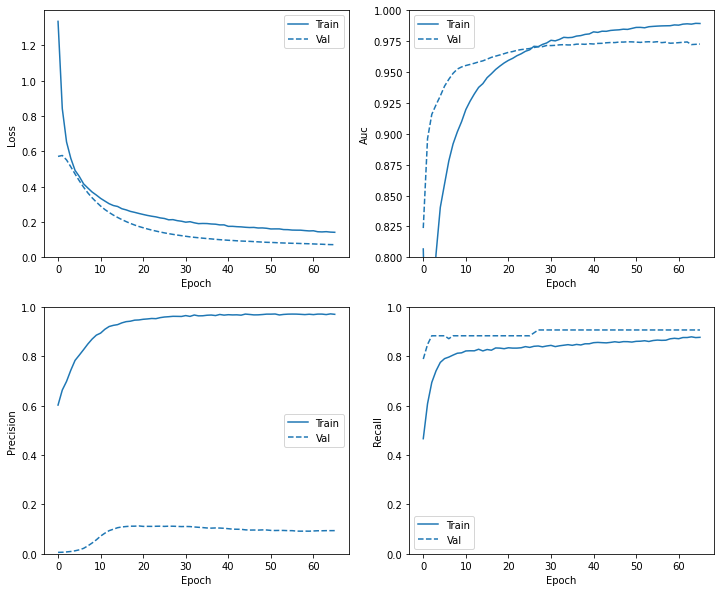

In [52]:
plot_metrics(resampled_history)

### 메트릭 평가

In [53]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.07805436849594116
tp :  82.0
fp :  923.0
tn :  55945.0
fn :  12.0
accuracy :  0.98358553647995
precision :  0.08159203827381134
recall :  0.8723404407501221
auc :  0.9706520438194275
prc :  0.698624849319458

Legitimate Transactions Detected (True Negatives):  55945
Legitimate Transactions Incorrectly Detected (False Positives):  923
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  82
Total Fraudulent Transactions:  94


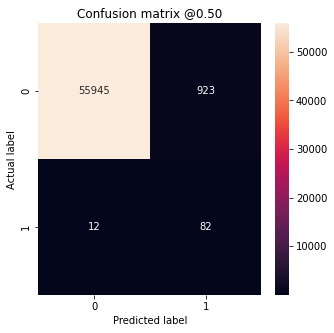

In [54]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### ROC 플로팅

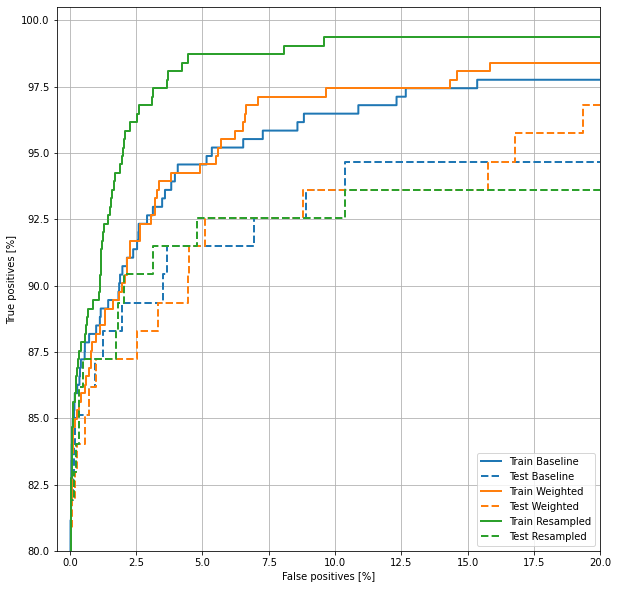

In [55]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

### AUPRC 플로팅


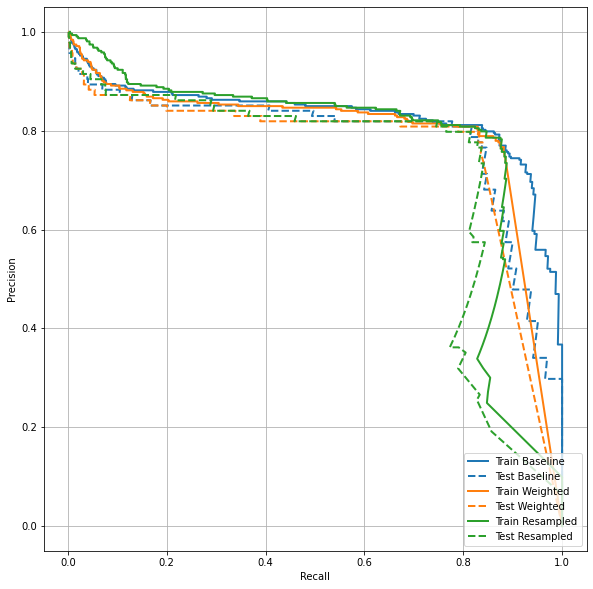

In [56]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

## 튜토리얼을 이 문제에 적용

불균형 데이터 분류는 학습 할 샘플이 너무 적기 때문에 본질적으로 어려운 작업입니다. 항상 데이터부터 시작하여 가능한 한 많은 샘플을 수집하고 모델이 소수 클래스를 최대한 활용할 수 있도록 어떤 기능이 관련 될 수 있는지에 대해 실질적인 생각을 하도록 최선을 다해야 합니다. 어떤 시점에서 모델은 원하는 결과를 개선하고 산출하는데 어려움을 겪을 수 있으므로 문제의 컨텍스트와 다양한 유형의 오류 간의 균형을 염두에 두는 것이 중요합니다.